In [2]:
import json
import os, re
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

In [3]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

In [4]:
files = []
for file in os.listdir('data'):
    if re.match('^20170610.*jsons', file):
        files.append(file)

In [5]:
def parseJsons(file):
    with open('data/{}'.format(file)) as f:
        sl = []
        for i, line in enumerate(f):
            _s = pd.read_json(line, typ='series')
            sl.append(_s)
        df = pd.concat(sl, axis=1).T
        df['time'] = df['time'].astype(float)
        df['acc'] = df['acc'].astype(float)
        df['loss'] = df['loss'].astype(float)
    return df

In [6]:
for i, file in enumerate(files):
    if i == 0:
        df_all = parseJsons(file)
    else:
        df_all = df_all.append(parseJsons(file))

In [45]:
_dprint = df_all.groupby(['dataset', 'architecture','instance_type'])['time','loss'].aggregate({'time' : [np.mean, np.std], 'loss' : ['min']})
_dprint['Czas (s)'] = '$'+_dprint['time']['mean'].round(2).astype(str)+'+/-'+_dprint['time']['std'].round(2).astype(str)+'$'
_dprint.columns = _dprint.columns.get_level_values(0)

In [46]:
print(_dprint[['Czas (s)']].to_latex())

\begin{tabular}{llll}
\toprule
      &        &            &         Czas (s) \\
dataset & architecture & instance\_type &                  \\
\midrule
cifar & custom & c4.2xlarge &  \$133.11+/-0.32\$ \\
      &        & p2.xlarge &   \$20.15+/-0.12\$ \\
      & kerasdef & c4.2xlarge &  \$116.36+/-0.45\$ \\
      &        & p2.xlarge &    \$21.65+/-0.1\$ \\
imdb &        & c4.2xlarge &  \$124.71+/-0.12\$ \\
      &        & p2.xlarge &   \$10.23+/-0.44\$ \\
      & lstmkerasdef & c4.2xlarge &   \$45.94+/-0.43\$ \\
      &        & p2.xlarge &   \$39.94+/-1.22\$ \\
mnist & custom & c4.2xlarge &   \$94.28+/-0.23\$ \\
      &        & p2.xlarge &   \$12.81+/-0.21\$ \\
      & kerasdef & c4.2xlarge &    \$81.5+/-2.68\$ \\
      &        & p2.xlarge &  \$16.73+/-21.45\$ \\
\bottomrule
\end{tabular}



In [9]:
df_all = df_all.reset_index()
df_all['data_arch'] = df_all['dataset'] + '_' + df_all['architecture']

In [10]:
df_grp = df_all.sort_values(by='data_arch').groupby('data_arch')

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[14, 18], sharey=False)
fig.subplots_adjust(hspace=0.3,wspace=0.1)
boxprops=dict(linewidth=1.5, color='1')

# Loop through each group and plot boxplot to appropriate axis
for i, k in enumerate(sorted(list(df_grp.groups.keys()))):
    group = df_grp.get_group(k)
    group.boxplot(ax=axes[floor(i/2)][i%2],
                  column='time',
                  by='instance_type',
                  boxprops=boxprops,
                  return_type='axes')
    axes[floor(i/2)][i%2].set_title('Zbiór danych: {}\nArchitektura: {}'.format(k.split('_')[0], k.split('_')[1]))
    axes[floor(i/2)][i%2].set_xlabel('Typ instancji')
    axes[floor(i/2)][i%2].set_ylabel('Czas obliczeń (s)')

fig.suptitle('')

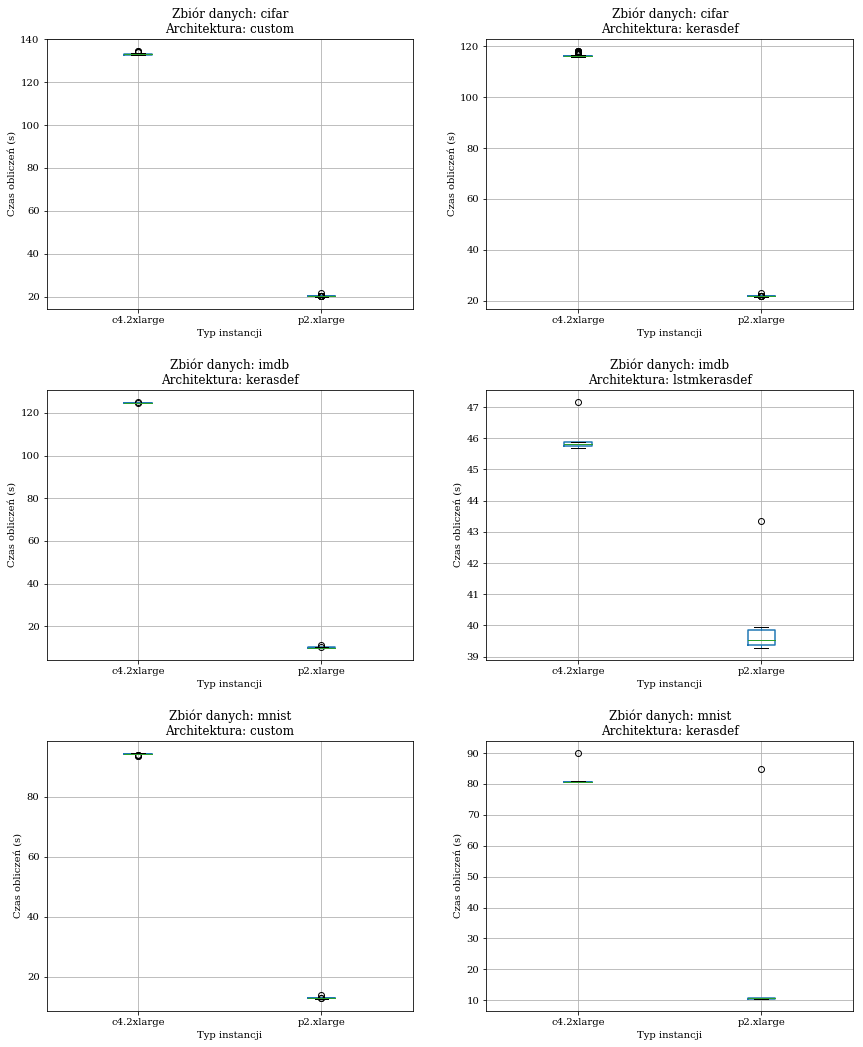

In [12]:
#fig.savefig('fig:experiment_results.png')
plt.show()

In [43]:
_dprint = df_all.groupby(['dataset', 'architecture','instance_type'])['loss','val_loss'].aggregate({'acc' : ['max'], 'val_acc' : ['max'], 'loss' : ['min'], 'val_loss' : ['min']})
_dprint['Funkcja straty (zbiór treningowy)'] = '$'+_dprint['loss'].round(4).astype(str)+'$'
_dprint['Funkcja straty (zbiór walidacyjny)'] = '$'+_dprint['val_loss'].round(4).astype(str)+'$'
_dprint['Trafność (zbiór treningowy)'] = '$'+_dprint['acc'].round(4).astype(str)+'$'
_dprint['Trafność (zbiór walidacyjny)'] = '$'+_dprint['val_acc'].round(4).astype(str)+'$'
_dprint.columns = _dprint.columns.get_level_values(0)

In [44]:
print(_dprint.ix[:,4:9].to_latex())

\begin{tabular}{lllllll}
\toprule
      &        &            & Funkcja straty (zbiór treningowy) & Funkcja straty (zbiór walidacyjny) & Trafność (zbiór treningowy) & Trafność (zbiór walidacyjny) \\
dataset & architecture & instance\_type &                                   &                                    &                             &                              \\
\midrule
cifar & custom & c4.2xlarge &                           \$0.218\$ &                           \$0.4204\$ &                    \$0.9309\$ &                     \$0.8743\$ \\
      &        & p2.xlarge &                          \$0.2207\$ &                           \$0.4083\$ &                    \$0.9308\$ &                     \$0.8767\$ \\
      & kerasdef & c4.2xlarge &                          \$0.6217\$ &                           \$0.6494\$ &                    \$0.7935\$ &                     \$0.7874\$ \\
      &        & p2.xlarge &                          \$0.6031\$ &                           \$

/home/roni/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [13]:
%matplotlib inline

In [14]:
tmp = df_all
tmp['timecum'] = df_all.sort_values(by='epoch').groupby(['data_arch','instance_type']).cumsum()['time']
df_grp = tmp.groupby('data_arch')
#tmp = df_all[(df_all['data_arch'] == 'mnist_custom')]
#tmp['timecum'] = tmp.sort_values(by='epoch').groupby('instance_type').cumsum()['time']

In [15]:
lsd = {'c4.2xlarge':'solid', 'p2.xlarge':'dashed'}

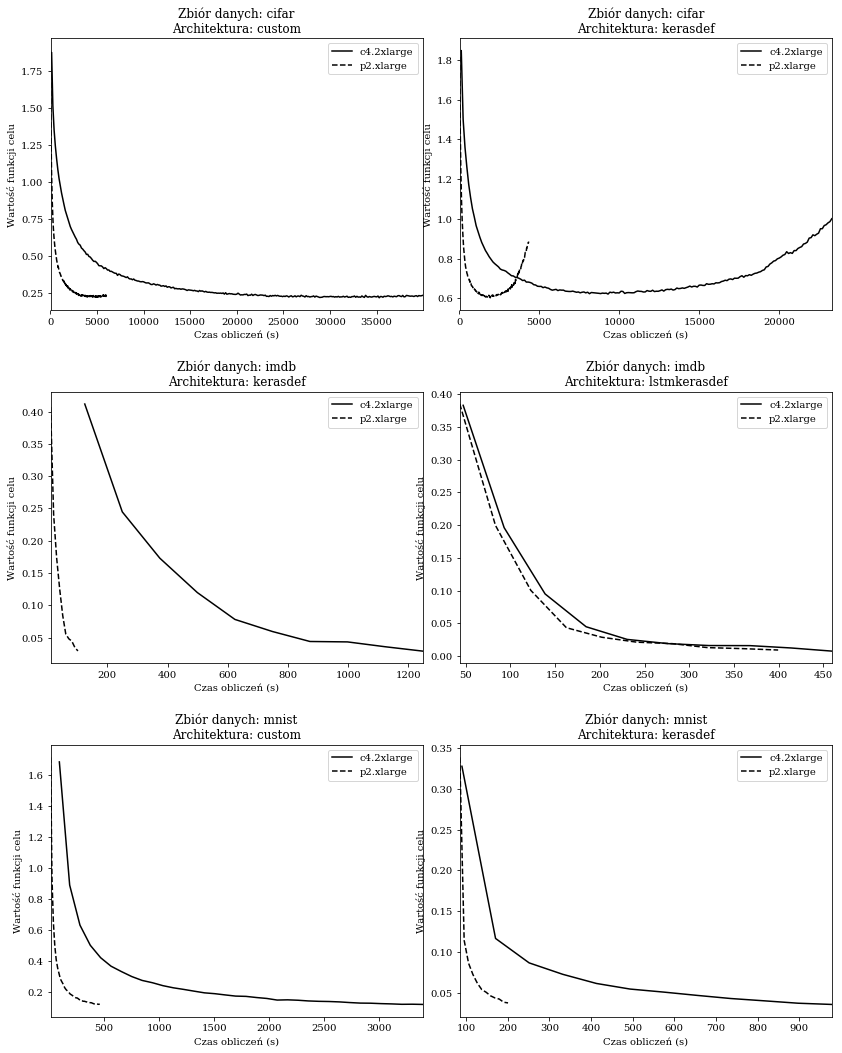

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[14, 18], sharey=False)
fig.subplots_adjust(hspace=0.3,wspace=0.1)

# Loop through each group and plot boxplot to appropriate axis
for i, k in enumerate(sorted(list(df_grp.groups.keys()))):
    group = df_grp.get_group(k)
    labels=[]
    for key, grp in group.groupby(['instance_type']):
        ax = grp.plot(ax=axes[floor(i/2)][i%2], kind='line', x='timecum', y='loss', c='black', ls=lsd.get(key))
        labels.append(key)
        lines, _ = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc=1)
    axes[floor(i/2)][i%2].set_title('Zbiór danych: {}\nArchitektura: {}'.format(k.split('_')[0], k.split('_')[1]))
    axes[floor(i/2)][i%2].set_xlabel('Czas obliczeń (s)')
    axes[floor(i/2)][i%2].set_ylabel('Wartość funkcji celu')

fig.suptitle('')

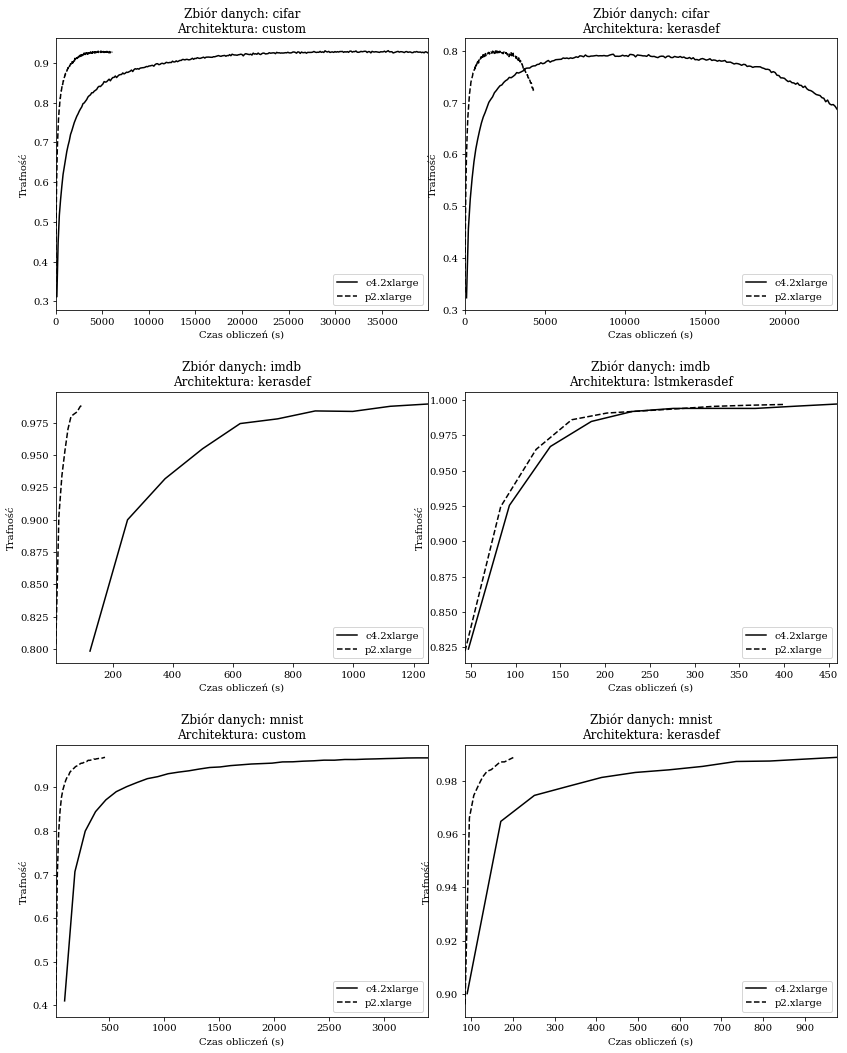

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[14, 18], sharey=False)
fig.subplots_adjust(hspace=0.3,wspace=0.1)

# Loop through each group and plot boxplot to appropriate axis
for i, k in enumerate(sorted(list(df_grp.groups.keys()))):
    group = df_grp.get_group(k)
    labels=[]
    for key, grp in group.groupby(['instance_type']):
        ax = grp.plot(ax=axes[floor(i/2)][i%2], kind='line', x='timecum', y='acc', c='black', ls=lsd.get(key))
        labels.append(key)
        lines, _ = ax.get_legend_handles_labels()
        ax.legend(lines, labels, loc=4)
    axes[floor(i/2)][i%2].set_title('Zbiór danych: {}\nArchitektura: {}'.format(k.split('_')[0], k.split('_')[1]))
    axes[floor(i/2)][i%2].set_xlabel('Czas obliczeń (s)')
    axes[floor(i/2)][i%2].set_ylabel('Trafność')

fig.suptitle('')

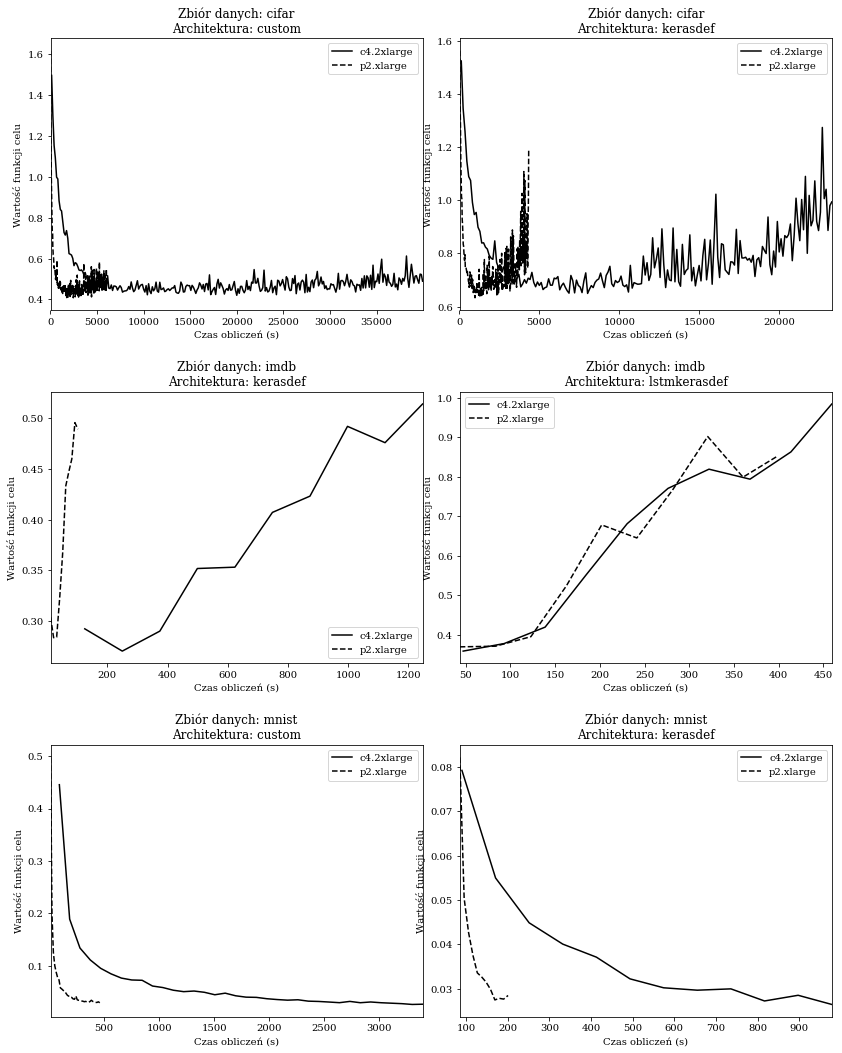

In [99]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[14, 18], sharey=False)
fig.subplots_adjust(hspace=0.3,wspace=0.1)

# Loop through each group and plot boxplot to appropriate axis
for i, k in enumerate(sorted(list(df_grp.groups.keys()))):
    group = df_grp.get_group(k)
    for key, grp in group.groupby(['instance_type']):
        ax = grp.plot(ax=axes[floor(i/2)][i%2], kind='line', x='timecum', y='val_loss', c='black', ls=lsd.get(key))
        labels.append(key)
    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    axes[floor(i/2)][i%2].set_title('Zbiór danych: {}\nArchitektura: {}'.format(k.split('_')[0], k.split('_')[1]))
    axes[floor(i/2)][i%2].set_xlabel('Czas obliczeń (s)')
    axes[floor(i/2)][i%2].set_ylabel('Wartość funkcji celu')

fig.suptitle('')

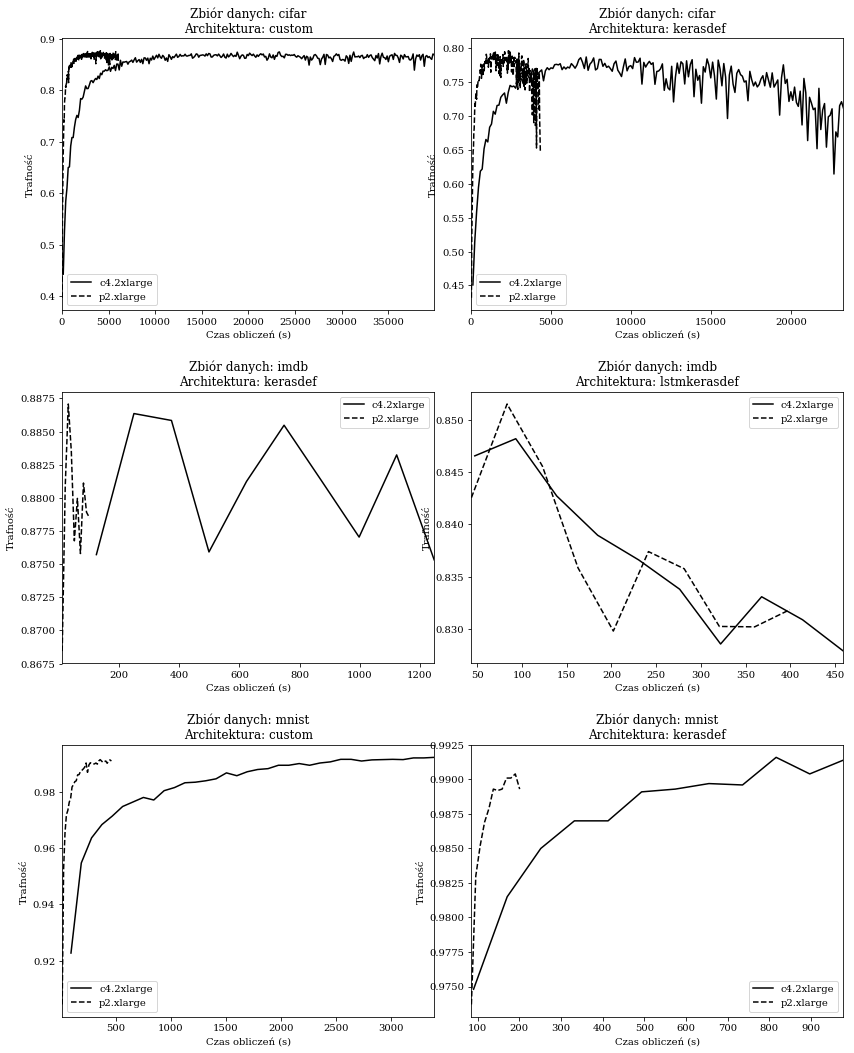

In [101]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[14, 18], sharey=False)
fig.subplots_adjust(hspace=0.3,wspace=0.1)

# Loop through each group and plot boxplot to appropriate axis
for i, k in enumerate(sorted(list(df_grp.groups.keys()))):
    group = df_grp.get_group(k)
    for key, grp in group.groupby(['instance_type']):
        ax = grp.plot(ax=axes[floor(i/2)][i%2], kind='line', x='timecum', y='val_acc', c='black', ls=lsd.get(key))
        labels.append(key)
    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    axes[floor(i/2)][i%2].set_title('Zbiór danych: {}\nArchitektura: {}'.format(k.split('_')[0], k.split('_')[1]))
    axes[floor(i/2)][i%2].set_xlabel('Czas obliczeń (s)')
    axes[floor(i/2)][i%2].set_ylabel('Trafność')

fig.suptitle('')